#### Copio códigos verificados de main.ipynb con intenciones de streamlinear el cálculo

In [3]:
import numpy as np
import pandas as pd
import healpy as hp
from scipy.interpolate import interp1d
from numpy.polynomial.polynomial import Polynomial

def build_cdf_from_parabola(data, vmin, vmax, deg, num_points=10000):
    # Create a histogram of the redshifts
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=deg)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals
  

def generate_random_catalogue(ra,dec,redshift,nside,nrand):

    # Total number of pixels in the map
    npix = hp.nside2npix(nside)

    # Initialize a mask array (1 = valid, 0 = invalid)
    mask = np.zeros(npix, dtype=int)

    # Convert RA, Dec to Healpix indices
    theta = np.radians(90 - dec)  # Declination to colatitude
    phi = np.radians(ra)          # Right Ascension to longitude
    pixels = hp.ang2pix(nside, theta, phi)

    # Mark these pixels as valid
    mask[pixels] = 1

    num_randoms = int(5e7)  # Number of random points

    # Generate uniform random RA, Dec
    ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
    u = np.random.uniform(-1, 1, num_randoms)
    dec_random_rad = np.arcsin(u)
    dec_random = np.rad2deg(dec_random_rad)
    #dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

    # Convert RA, Dec to Healpix indices
    theta_random = np.radians(90 - dec_random)
    phi_random = np.radians(ra_random)
    random_pixels = hp.ang2pix(nside, theta_random, phi_random)

    # Apply the mask
    valid_indices = mask[random_pixels] == 1
    ra_random = ra_random[valid_indices]
    dec_random = dec_random[valid_indices]

    # Read redshift distribution and apply to randoms
    # Build the inverse CDF from a smoothed KDE fit
    cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(redshift, redshift.min(), redshift.max(), deg)

    # Generate random redshifts
    u = np.random.uniform(0, 1, len(ra_random))
    red_random = cdf_inv_z(u)

    random_data = pd.DataFrame({
        'ra': ra_random[:len(ra)*nrand],
        'dec': dec_random[:len(ra)*nrand],
        'red': red_random[:len(ra)*nrand]
    })

    print(len(ra))
    print(len(random_data))
    print(len(random_data)/len(ra))

    return random_data

# Load galaxy data
zmin, zmax = 0.05, 0.15
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss  = cat_sdss[(cat_sdss["red"] >= zmin)*(cat_sdss["red"] <= zmax)]
cat_sdss = cat_sdss[cat_sdss['mag_abs_r']<-20.5]

ra = cat_sdss['ra'].values  # Right Ascension
dec = cat_sdss['dec'].values  # Declination
redshift = cat_sdss['red'].values # Redshift

# Set the resolution (nside)
nside = 128  # Approx 55 arcmin resolution (adjust as needed)
nrand = 8 # Times the size of the data 

deg = 2
random_data = generate_random_catalogue(ra,dec,redshift,nside,nrand)
#random_data.to_csv(f'../data/random_sample_healpy_{nside}_{len(random_data)}.csv', index=False)


283494
2267952
8.0


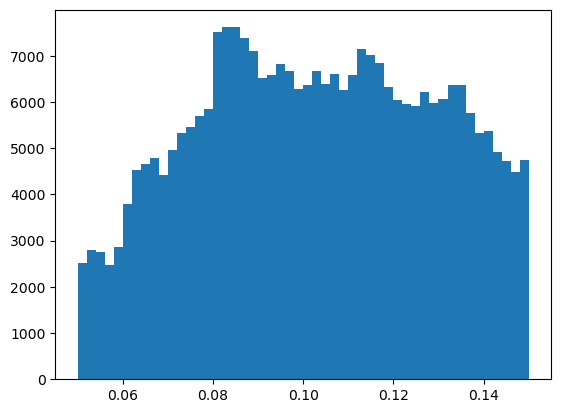

In [5]:
import matplotlib.pyplot as plt

plt.hist(cat_sdss['red'],bins=50,density=False)
#plt.hist(random_data['red'],bins=50,density=False,alpha=.7)
plt.show()

In [11]:
######################
minsep = 10.      # Min theta
maxsep = 150.      # Max theta
nbins = 30        # Bins in theta
nbootstrap = 0  # No. of bootstrap resampling
brute = False     # Brute force for TreeCorr
npatch = 0

config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            #"sep_units": 'degree', \
            "bin_type": 'Log', \
            #"brute": brute, \
            #"metric": 'Arc', \
            #"var_method": 'bootstrap', \
            #"num_bootstrap": nbootstrap,\
            }
######################

import numpy as np
import pandas as pd
import treecorr
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=100., Om0=0.3089)

def H(ra, dec, z):

  ra  = np.array(ra,  dtype=np.float32) 
  dec = np.array(dec, dtype=np.float32) 
  z   = np.array(z,   dtype=np.float32) 

  r = np.float32(cosmo.comoving_distance(z).value)
  x = r*np.cos(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
  y = r*np.sin(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
  z = r*np.sin(np.deg2rad(dec))
  return x, y, z

def calculate_xi(data,randoms,config,sample=None):

  # Transform to Cartesian
  #random = pd.DataFrame()
  #data = pd.DataFrame()

  randoms["x"], randoms["y"], randoms["z"] = H(randoms["ra"], randoms["dec"], randoms["red"])
  #data["x"], data["y"], data["z"] = H(data["ra"], data["dec"], data["red"])
  data.loc[:, ('x')],data.loc[:, ('y')],data.loc[:, ('z')] = H(data["ra"], data["dec"], data["red"])


  # TreeCorr Catalogues
  dd = treecorr.NNCorrelation(config)
  dr = treecorr.NNCorrelation(config)
  rr = treecorr.NNCorrelation(config)
  #rd = treecorr.NNCorrelation(config)

  rcat = treecorr.Catalog(x=randoms['x'], y=randoms['y'], z=randoms['z'])
  gcat = treecorr.Catalog(x=data['x'], y=data['y'], z=data['z'])

  dd.process(gcat)
  rr.process(rcat)
  dr.process(gcat,rcat)

  xi, varxi = dd.calculateXi(rr=rr,dr=dr)

  if sample!=None:
    rr.write('../data/rr.txt')
    dd.write('../data/dd.txt')
    dr.write('../data/dr.txt')
  else:
    rr.write(f'../data/rr_{sample}.txt')
    dd.write(f'../data/dd_{sample}.txt')
    dr.write(f'../data/dr_{sample}.txt')
  return xi, varxi, dd.meanr


In [12]:

# Read Randoms
#cat_random = pd.read_csv('../data/random_sample_healpy_128_561286.csv')

xi, varxi, s = calculate_xi(cat_sdss,random_data,config)

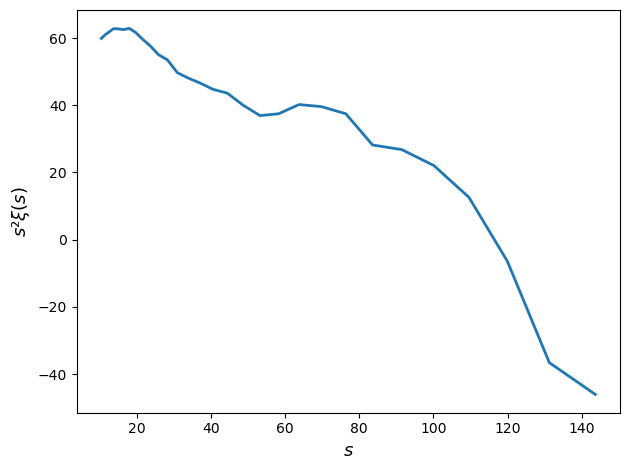

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
fslabel = 13

sig = np.sqrt(varxi)

#s = dd.meanr
plt.errorbar(s, xi*s**2, yerr=sig, color='C00', lw=2)

plt.xlabel(r'$s$', fontsize = fslabel)
plt.ylabel(r'$s²\xi(s)$', fontsize = fslabel)

plt.tight_layout()

plt.show()

plotname = '../plots/xi_s.png'
plt.savefig(plotname)

In [ ]:
# Load galaxy data
#zmin, zmax = 0.02, 0.2
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss  = cat_sdss[(cat_sdss["red"] >= zmin)*(cat_sdss["red"] <= zmax)]
cat_sdss = cat_sdss[cat_sdss['mag_abs_r']<-20.5]

# Define filament and non-filament galaxies
filgxs = cat_sdss[cat_sdss['dist_fil']<=3.]
nonfilgxs = cat_sdss[cat_sdss['dist_fil']>8.25]

# Create randoms for each sample
filgxs_cdf_inv_z = build_cdf_from_parabola(filgxs['red'].values, filgxs['red'].values.min(), filgxs['red'].values.max(), deg)[0]
u = np.random.uniform(0, 1, len(random_data))
random_filgxs_red = filgxs_cdf_inv_z(u)
random_filgxs = pd.DataFrame({
    'ra': random_data['ra'],
    'dec': random_data['dec'],
    'red': random_filgxs_red
}
)

# nonfilgxs_cdf_inv_z = build_cdf_from_parabola(nonfilgxs['red'].values, nonfilgxs['red'].values.min(), nonfilgxs['red'].values.max(), deg)[0]
# u = np.random.uniform(0, 1, len(random_data))
# random_nonfilgxs_red = nonfilgxs_cdf_inv_z(u)
# random_nonfilgxs = pd.DataFrame({
#     'ra': random_data['ra'],
#     'dec': random_data['dec'],
#     'red': random_nonfilgxs_red
# }
# )

xi_fil, varxi_fil, s_fil = calculate_xi(filgxs,random_filgxs,config,sample='fil')

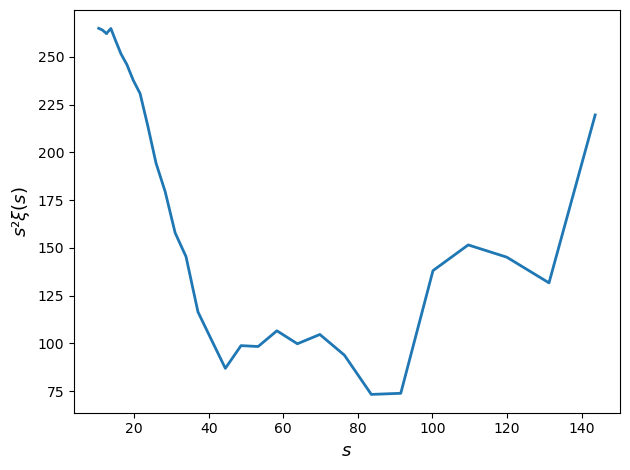

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
fslabel = 13

sig = np.sqrt(varxi_fil)

plt.errorbar(s_fil, xi_fil*s_fil**2, yerr=sig, color='C00', lw=2)

plt.xlabel(r'$s$', fontsize = fslabel)
plt.ylabel(r'$s²\xi(s)$', fontsize = fslabel)

plt.tight_layout()

plt.show()

plotname = '../plots/xi_s_fil.png'
plt.savefig(plotname)

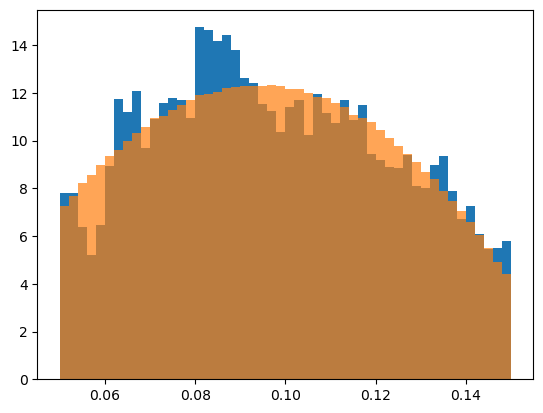

In [ ]:
plt.hist(filgxs['red'],bins=50,density=True)
plt.hist(random_filgxs['red'],bins=50,density=True,alpha=.7)
plt.show()